## Setup & Installation

In [1]:
%%writefile requirements.txt
diffusers

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

## 3. Create Custom Handler for Inference Endpoints


In [1]:
%%writefile handler.py
from typing import  Dict, List, Any
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import base64
from io import BytesIO


# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EndpointHandler():
    def __init__(self, path=""):
        # load the optimized model
        self.pipe = StableDiffusionPipeline.from_pretrained(path, torch_dtype=torch.float16)
        self.pipe = self.pipe.to(device)


    def __call__(self, data: Any) -> List[List[Dict[str, float]]]:
        """
        Args:
            data (:obj:):
                includes the input data and the parameters for the inference.
        Return:
            A :obj:`dict`:. base64 encoded image
        """
        inputs = data.pop("inputs", data)
        
        # run inference pipeline
        with autocast(device.type):
            image = self.pipe(inputs, guidance_scale=7.5)["sample"][0]  
            
        # encode image as base 64
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue())

        # postprocess the prediction
        return {"image": img_str}

Overwriting handler.py


test custom pipeline

In [2]:
from handler import EndpointHandler

# init handler
my_handler = EndpointHandler(path=".")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA SETUP: CUDA runtime path found: /home/ubuntu/miniconda/envs/dev/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /home/ubuntu/miniconda/envs/dev/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda113.so...


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


0it [00:00, ?it/s]

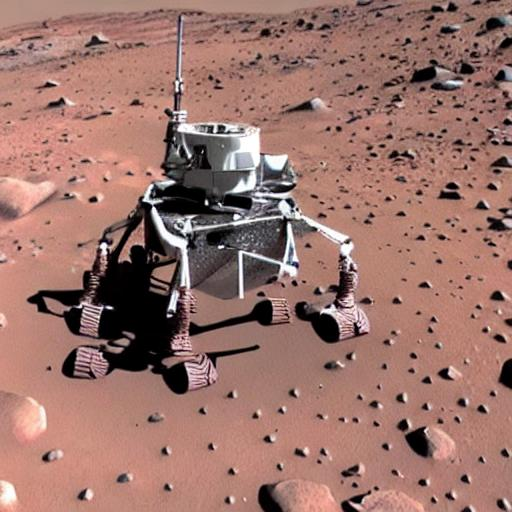

In [6]:
import base64
from PIL import Image
from io import BytesIO

# helper decoder
def decode_base64_image(image_string):
  base64_image = base64.b64decode(image_string)
  buffer = BytesIO(base64_image)
  return  Image.open(buffer)

# prepare sample payload
request = {"inputs": "the first animal on the mars"}

# test the handler
pred = my_handler(request)

# decode image
decode_base64_image(pred["image"])

In [7]:
decode_base64_image(pred["image"]).save("sample.jpg")